## Discretisation plus Encoding

What shall we do with the variable after discretisation? should we use the buckets as a numerical variable? or should we use the intervals as categorical variable?

The answer is, you can do either.

If you are building decision tree based algorithms and the output of the discretisation are integers (each integer referring to a bin), then you can use those directly, as decision trees will pick up non-linear relationships between the discretised variable and the target.

If you are building linear models instead, the bins may not necessarily hold a linear relationship with the target. In this case, it may help improve model performance to treat the bins as categories and to one hot encoding, or target guided encodings like mean encoding, weight of evidence, or target guided ordinal encoding.

We can easily do so by combining feature-engine's discretisers and encoders.

## In this demo

We will perform equal frequency discretisation followed by target guided orginal encoding.

If instead you would like to do weight of evidence or mean target encoding, you need only replace the Feature-engine's encoder.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisers import EqualFrequencyDiscretiser
from feature_engine.categorical_encoders import OrdinalCategoricalEncoder

## DATASET

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)

In [2]:
data_raw = pd.read_csv('C://Users/gusal/machine learning/Feature engineering/auto-mpg_rev1.csv')

In [3]:
data_raw.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,16.0,8,304.0,150.0,3433.0,12.0,70,1
2,15.0,8,429.0,198.0,4341.0,10.0,70,1
3,14.0,8,454.0,220.0,4354.0,9.0,70,1
4,14.0,8,440.0,215.0,4312.0,8.5,70,1


In [4]:
inputs = data_raw.drop(['mpg'], axis = 1)
target = data_raw.mpg

In [5]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    inputs,
    target,
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((247, 7), (106, 7))

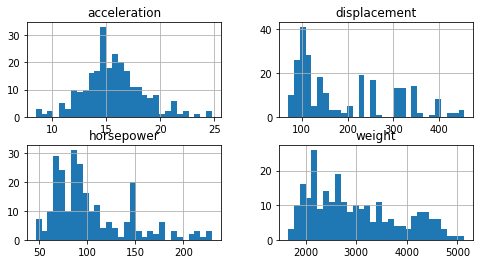

In [6]:
# let's explore the distribution of age

X_train[['displacement','weight', 'horsepower','acceleration']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal frequency discretisation with Feature-Engine

In [7]:
# set up the equal frequency discretiser
# to encode variables we need them returned as objects for feature-engine

disc = EqualFrequencyDiscretiser(
    q=10, variables=['displacement','weight', 'horsepower','acceleration'], return_object=True)

# find the intervals
disc.fit(X_train)

# transform train and text
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [8]:
train_t.dtypes

cylinders        int64
displacement    object
horsepower      object
weight          object
acceleration    object
model year       int64
origin           int64
dtype: object

In [10]:
# in the map, we map bin to position
disc.binner_dict_

{'displacement': [-inf,
  90.0,
  97.6,
  108.0,
  121.0,
  141.0,
  200.0,
  250.0,
  304.0,
  350.0,
  inf],
 'weight': [-inf,
  1985.0,
  2136.8,
  2298.0,
  2562.4,
  2740.0,
  3018.6000000000004,
  3386.8000000000006,
  3811.4000000000005,
  4346.2,
  inf],
 'horsepower': [-inf,
  65.0,
  71.0,
  78.0,
  86.4,
  90.0,
  100.0,
  110.0,
  140.0,
  156.20000000000002,
  inf],
 'acceleration': [-inf,
  12.5,
  13.5,
  14.4,
  14.9,
  15.5,
  16.0,
  16.82,
  17.7,
  19.0,
  inf]}

In [11]:
train_t.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
224,6,7,7,7,4,78,1
275,4,4,4,5,8,80,1
124,6,6,6,7,5,75,1
171,6,7,5,6,8,76,1
306,4,0,0,0,9,81,3


Text(0, 0.5, 'mean of mpg')

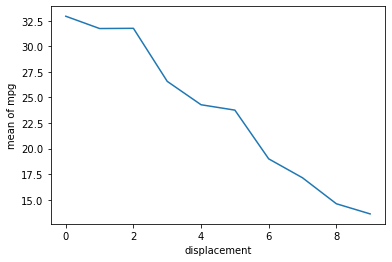

In [12]:
# let's explore if the bins have a linear relationship
# with the target:

pd.concat([train_t, y_train], axis=1).groupby('displacement')['mpg'].mean().plot()
plt.ylabel('mean of mpg')

Text(0, 0.5, 'mean of mpg')

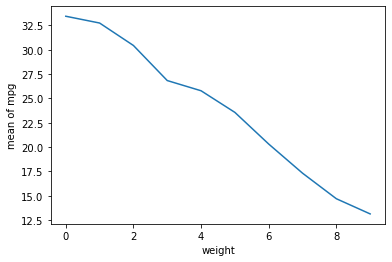

In [13]:
# let's explore if the bins have a linear relationship
# with the target:

pd.concat([train_t, y_train], axis=1).groupby('weight')['mpg'].mean().plot()
plt.ylabel('mean of mpg')

Text(0, 0.5, 'mean of mpg')

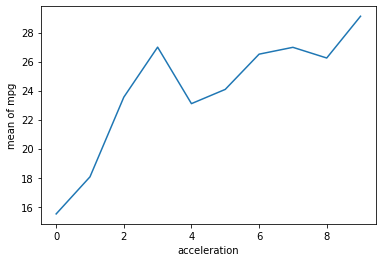

In [14]:
# let's explore if the bins have a linear relationship
# with the target:

pd.concat([train_t, y_train], axis=1).groupby('acceleration')['mpg'].mean().plot()
plt.ylabel('mean of mpg')

Text(0, 0.5, 'mean of mpg')

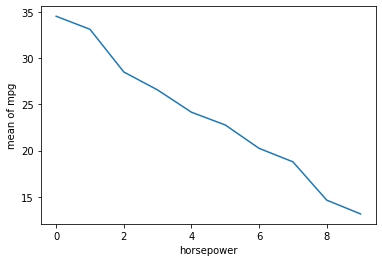

In [15]:
# let's explore if the bins have a linear relationship
# with the target:

pd.concat([train_t, y_train], axis=1).groupby('horsepower')['mpg'].mean().plot()
plt.ylabel('mean of mpg')

In [16]:
train_t.acceleration.head()

224    4
275    8
124    5
171    8
306    9
Name: acceleration, dtype: object

All of the variables, except acceleration show a monotonic relationship between the intervals of the discrete variable and the mean of mpg. We can encode the intervals to return a monotonic relationship for all the variables:

# Ordinal encoding with Feature-Engine

In [17]:
enc = OrdinalCategoricalEncoder(encoding_method = 'ordered')

enc.fit(train_t, y_train)

train_t = enc.transform(train_t)
test_t = enc.transform(test_t)

In [18]:
# in the map, we map bin to position

enc.encoder_dict_

{'displacement': {9: 0, 8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 1: 7, 2: 8, 0: 9},
 'horsepower': {9: 0, 8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8, 0: 9},
 'weight': {9: 0, 8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8, 0: 9},
 'acceleration': {0: 0, 1: 1, 4: 2, 2: 3, 5: 4, 8: 5, 6: 6, 7: 7, 3: 8, 9: 9}}

Text(0, 0.5, 'mean of mpg')

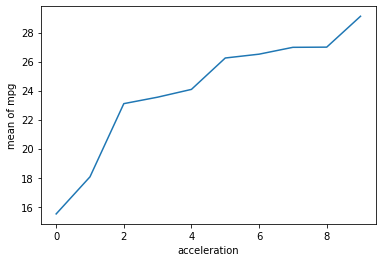

In [19]:
pd.concat([train_t, y_train], axis=1).groupby('acceleration')['mpg'].mean().plot()
plt.ylabel('mean of mpg')

Now we obtained a monotonic relationship between variable acceleration and target.

Text(0, 0.5, 'mean of mpg')

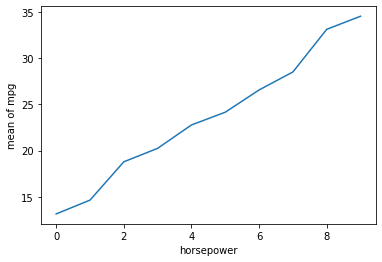

In [22]:
# let's explore if the bins have a linear relationship
# with the target:

pd.concat([train_t, y_train], axis=1).groupby('horsepower')['mpg'].mean().plot()
plt.ylabel('mean of mpg')

In [20]:
train_t.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
224,6,2,2,2,2,78,1
275,4,5,5,4,5,80,1
124,6,3,3,2,4,75,1
171,6,2,4,3,5,76,1
306,4,9,9,9,9,81,3
